In [203]:
%%HTML
<style> code {background-color : pink !important;} </style>

Load in Vehicle and non Vehicle images
===


In [204]:

import glob
import os

%matplotlib qt
import numpy as np

vehicle_images = 'vehicles/'
images = os.listdir(vehicle_images)

vehicles = []

for image in images:
    vehicles.extend(glob.glob(vehicle_images+image+'/G*/*'))
    vehicles.extend(glob.glob(vehicle_images+image+'/K*/*'))

print("No of vehicles images: ", len(vehicles))

non_vehicle_images = 'non-vehicles/'
images = os.listdir(non_vehicle_images)

non_vehicles = []

for image in images:
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/GTI*/*'))
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/E*/*'))

print("No of vehicles images: ", len(non_vehicles))


No of vehicles images:  8792
No of vehicles images:  8968


### Visualize a random Vehicle and non Vehicle image

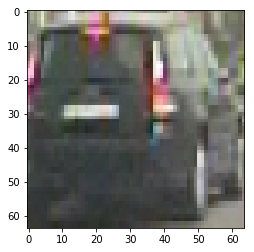

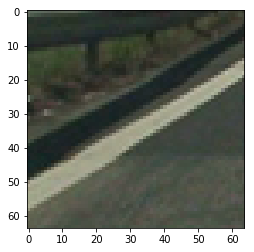

In [205]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

rnd = np.random.randint(0, len(non_vehicles))
img = mpimg.imread(non_vehicles[rnd])
plt.imshow(img)
plt.show()

## Define relevant functions

### Define HOG features

In [249]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec):
    
    if vis:
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, visualise=True, feature_vector=feature_vec, block_norm = 'L2-Hys')
        return hog_features, hog_image
    
    else:       
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, visualise=False, feature_vector=feature_vec, block_norm = 'L2-Hys')                
        return hog_features

    

### Test HOG features function

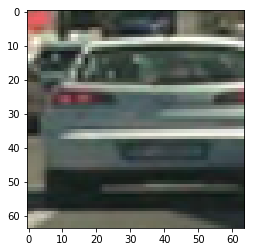

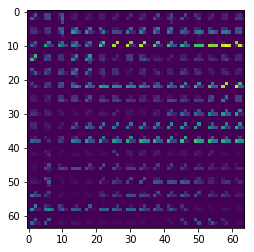

In [251]:
import cv2
# Select a random vehicle image

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features, hog_img = get_hog_features(img[:,:,0], orient= 20, 
                        pix_per_cell= 4, cell_per_block= 2, 
                        vis=True, feature_vec=True)
plt.imshow(hog_img)
plt.show()


### Define spatial bins and color histograms

In [272]:
# Define a function to compute color histogram features

def color_hist(img, nbins):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, color_space, size):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'HUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HUV)
    else: feature_image = np.copy(img)  
        
    # Extract each color channel
    color1 = cv2.resize(feature_image[:,:,0], size).ravel()
    color2 = cv2.resize(feature_image[:,:,1], size).ravel()
    color3 = cv2.resize(feature_image[:,:,2], size).ravel()
     # Use cv2.resize().ravel() to create the feature vector
    features = np.hstack((color1, color2, color3))
    # Return the feature vector
    return features

### Test on random image

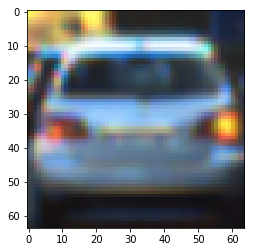

[288 291 415 267 215 160 127  96 168 189 312 182 215 109 120 102 119  84
  80  73  45  39  49  38  52  65  33  34  25  42  16  46 276 151 320 252
 208 155 207 135 152 107 135 112 164 166 205 174 153 104  75  88 107 100
  97 104  86  69  27  30  33  38  23  43 177 217 230 195 208 220 227 183
 151 140 167 133 105  88 106 148 153 141 128 108  78  73  40  44  64  57
  76  59  79  75  91 135]
96
[ 0.99019611  0.99019611  0.97843134 ...,  0.08039216  0.08235294
  0.0882353 ]
3072


In [213]:

hist_features = color_hist(img, nbins = 32)
plt.imshow(img)
plt.show()
print(hist_features)
print(len(hist_features))

spatial_features = bin_spatial(img, color_space = 'RGB', size=(32,32))
print(spatial_features)
print(len(spatial_features))

### Define a function that applies above functions to the dataset

In [256]:
# The function below takes ina list of images and extract feature vectrs from each and returns the feature vector

def extract_features(imgs, orient, pix_per_cell, cell_per_block, vis, feature_vec, hog_channel,
                   nbins, color_space, size, spatial_feat, hist_feat, hog_feat):
    
    # Create a feature vector
    features = []
    
    # Iterate through all the images
    for img in imgs:
        img_features = []
        
        # read in the image
        image = mpimg.imread(img)
        
        if spatial_feat:
            # extract spatial features
            spatial_features = bin_spatial(image, color_space, size)
            # append to image features vector
            img_features.append(spatial_features)
        
        if hist_feat:
            # extract color histograms
            hist_features = color_hist(image, nbins)
            # append to image features vector
            img_features.append(hist_features)
        
        if hog_feat:
            # Extract hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    hog_features.append(get_hog_features(image[:,:,channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec))
                hog_features = np.ravel(hog_features)

            elif hog_channel == 'GRAY':
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                hog_features  = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec)
            
            # append to image features
            img_features.append(hog_features)
    
        # append the image feature vector to the global feature vector
        features.append(np.concatenate(img_features))
    
    # return the feature vector of all images
    return features

### Define a sliding window

In [215]:
# The routine below takes in a region of interest and returns bouding boxes

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Define a function for drawing bounding boxes

In [216]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### Run classifier on vehicle and non vehicle images

In [277]:
# Set the parameters to tune the classifier
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


orient = 18
pix_per_cell = 4
cell_per_block = 2
vis = False
feature_vec = True 
hog_channel = 'ALL' # could be ALL, 0, 1 , 2
nbins = 32 # no of bins for histogram
color_space = 'RGB' # could be RGB, HUV, HLV, YCrCb, YUV, HSV
size = (32, 32) # spatial binning dimension
spatial_feat = True # to turn spatial features on and off
hist_feat = True # to turn histogram features on and off
hog_feat = True # to turn HOG features on and off

t = time.time()
n_samples = 1000
rand = np.random.randint(0, len(vehicles), n_samples)

test_vehicles = np.array(vehicles)
test_non_vehicles = np.array(non_vehicles)

print("Extracting features ...")

vehicle_features = extract_features(test_vehicles, orient, pix_per_cell, cell_per_block, vis, feature_vec,
                                   hog_channel, nbins, color_space, size, spatial_feat, hist_feat, hog_feat)

non_vehicle_features = extract_features(test_non_vehicles, orient, pix_per_cell, cell_per_block, vis, feature_vec,
                                   hog_channel, nbins, color_space, size, spatial_feat, hist_feat, hog_feat)

print(int(time.time()-t+1), "Seconds to complete feature extraction")

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# fit a per column scaler
X_scaler = StandardScaler().fit(X)

# apply transform to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state = rand_state)

print("Feature vector length: ", len(X_train))

svc = LinearSVC()
t = time.time()

print("Training using SVC...")
svc.fit(X_train, y_train)

print(int(time.time()-t), "seconds to train ")
print("Test accuracy of SVC: ", svc.score(X_test, y_test))

Extracting features ...
775 Seconds to complete feature extraction


MemoryError: 

### Apply Perspective transform

In [13]:


def PerspectiveTransform(img, warp):
    
    img_size = (img.shape[1], img.shape[0])

    # sequence of co ordinates, bottom left, bottom right, top left, top right
    
    src = np.float32(
            [[250, 650],
           [1100, 650],
           [570, 460],
           [710, 460]])
    dst = np.float32(
            [[0, img.shape[0]],
             [1300, img.shape[0]],
             [0, 0],
             [1300, 0]])
    
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

    

In [14]:
# apply perspective transform on test images

#output_images_path = 'combined_binaries/'
#test_image = os.listdir(output_images_path)

def Warp_Image(img, warp):
    
    #plt.gca().set_title(image)
    #plt.imshow(img)
    #plt.show()

    warped = PerspectiveTransform(img, warp)
    warped*=255
    
    return warped

'''
for image in test_image: 
    # load image
    img = mpimg.imread(output_images_path+image)
    warped = Warp_Image(img, True)
    cv2.imwrite('warped_images/'+image, warped)
    plt.gca().set_title('Warped')
    plt.imshow(warped)
    plt.show()
    
    unwarped = Warp_Image(warped, False)
    plt.imshow(unwarped)
    plt.show()
'''

"\nfor image in test_image: \n    # load image\n    img = mpimg.imread(output_images_path+image)\n    warped = Warp_Image(img, True)\n    cv2.imwrite('warped_images/'+image, warped)\n    plt.gca().set_title('Warped')\n    plt.imshow(warped)\n    plt.show()\n    \n    unwarped = Warp_Image(warped, False)\n    plt.imshow(unwarped)\n    plt.show()\n"

### Sliding Window Search to detect lane lines

In [15]:
'''
img = mpimg.imread('warped_images/test2.jpg')
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.imshow(img)
plt.show()
plt.plot(histogram)
'''

"\nimg = mpimg.imread('warped_images/test2.jpg')\nhistogram = np.sum(img[img.shape[0]//2:,:], axis=0)\nplt.imshow(img)\nplt.show()\nplt.plot(histogram)\n"

In [4]:
def Undistort_Image(img):

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [5]:
# sobel x and sobel y
def abs_sobel_thresh(img, orient, sobel_kernel=3, thresh=(0, 255)):

    if orient == 'x':
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        abs_sobel = np.absolute(sobelx)

    elif orient == 'y':
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobel = np.absolute(sobely)

    else:
        sobelx = sobely = abs_sobel = 0

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return binary

In [6]:
def hls_threshold(img, cspace, thresh=(90, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    if cspace == 'H':
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        return binary
    elif cspace == 'L':
        binary = np.zeros_like(L)
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        return binary
    elif cspace == 'S':
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        return binary
    else:
        binary = np.zeros_like(H)
        return binary

In [7]:
def Combined_Binary(img):

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find gradient in X direction
    absx = abs_sobel_thresh(gray, 'x', sobel_kernel = 3, thresh = (120, 230))

    # find gradient in Y direction
    absy = abs_sobel_thresh(gray, 'y', sobel_kernel = 3, thresh = (120, 230))

    s = hls_threshold(img, 'S', thresh=(150, 250))

    color_binary = np.dstack((np.zeros_like(absx), np.zeros_like(absx), s))*255

    combined_binary = np.zeros_like(absx)
    combined_binary[(absx ==1) | (absy == 1) | (s == 1)] = 1
    combined_binary*=255
    
    return combined_binary

In [15]:
def PerspectiveTransform(img, warp):
    
    img_size = (img.shape[1], img.shape[0])

    # sequence of co ordinates, bottom left, bottom right, top left, top right
    
    src = np.float32(
            [[250, 650],
           [1080, 650],
           [570, 460],
           [720, 460]])
    dst = np.float32(
            [[0, img.shape[0]],
             [1200, img.shape[0]],
             [0, 0],
             [1200, 0]])
    
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
        
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

In [16]:
def Warp_Image(img, warp):

    warped = PerspectiveTransform(img, warp)
    warped*=255
    
    return warped

### Code to perform perspective transform

In [17]:

def find_lanes(img):
    
    # Undistort Image
    
    undist = Undistort_Image(img)
    
    # Create a combined binary
    
    combined_binary = Combined_Binary(undist)
    
    # Warp the binary image after applying perspective transform
    
    binary_warped = Warp_Image(combined_binary, True)
    
    #binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 25
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0, 255, 0), 5) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0, 255, 0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    global first_pass 
    
    global prev_left_fit
    global prev_right_fit
    global avg_left_fit
    global avg_right_fit
        
    if first_pass:
            
        for i in range(len(left_fit)):
            
            avg_left_fit.append(left_fit[i])

            avg_right_fit.append(right_fit[i])

            prev_left_fit.append(left_fit[i])

            prev_right_fit.append(right_fit[i])

        first_pass = False
    else:

        for i in range(len(left_fit)):     
            
            avg_left_fit[i] = (left_fit[i] + avg_left_fit[i])/2
            avg_right_fit[i] = (right_fit[i] + avg_right_fit[i])/2

            prev_left_fit[i] = left_fit[i]
            prev_right_fit[i] = right_fit[i]

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = avg_left_fit[0]*ploty**2 + avg_left_fit[1]*ploty + avg_left_fit[2]
    right_fitx = avg_right_fit[0]*ploty**2 + avg_right_fit[1]*ploty + avg_right_fit[2]

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = 205
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = 55
    
    window_img = np.zeros_like(out_img)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-1.5*margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+30*margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-40*margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    
    
    #plt.plot(left_fitx, ploty, color='yellow', linewidth = 5)
    #plt.plot(right_fitx, ploty, color='red', linewidth = 5)
    plt.imshow(window_img)
    #plt.show()
    plt.imshow(out_img)
    #plt.show()
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    #plt.show()
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    result = Warp_Image(result, False)
    result = cv2.addWeighted(img, 1, result, 1, 0)
    return result

    

#test_images_path = 'test_images/'
#test_images = os.listdir(test_images_path)

'''
for image in test_images: 
    
    img = cv2.imread(test_images_path+image)
    out_img = find_lanes(img)
    #out_img = cv2.addWeighted(img, 1, out_img, 3, 0)
    plt.gca().set_title(image)
    plt.imshow(out_img)
    plt.show()
''' 

'\nfor image in test_images: \n    \n    img = cv2.imread(test_images_path+image)\n    out_img = find_lanes(img)\n    #out_img = cv2.addWeighted(img, 1, out_img, 3, 0)\n    plt.gca().set_title(image)\n    plt.imshow(out_img)\n    plt.show()\n'

[MoviePy] >>>> Building video output_video/output.mp4
[MoviePy] Writing video output_video/output.mp4



 24%|██▍       | 303/1261 [00:39<02:05,  7.64it/s]


 48%|████▊     | 605/1261 [01:19<01:23,  7.87it/s]


 72%|███████▏  | 907/1261 [01:57<00:47,  7.53it/s]


 96%|█████████▌| 1205/1261 [03:34<00:23,  2.39it/s]


100%|█████████▉| 1260/1261 [04:16<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/output.mp4 

CPU times: user 3min 10s, sys: 13.4 s, total: 3min 24s
Wall time: 4min 20s


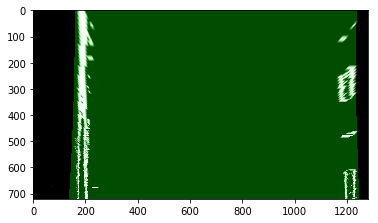

In [19]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test_videos/project_video.mp4'
output_video = 'output_video/output.mp4'

first_pass = True
avg_left_fit = []
avg_right_fit = []

prev_left_fit = []
prev_right_fit = []

clip = VideoFileClip(output)#.subclip(30,50)

white_clip = clip.fl_image(find_lanes) #NOTE: this function expects color images!! ,

%time white_clip.write_videofile(output_video, codec = 'mpeg4', audio=False)